In [1]:
import os
os.chdir("/oak/stanford/groups/akundaje/kobbad/UCE")
from model import *
import scanpy as sc
from tqdm.auto import tqdm
from torch import nn, Tensor
from evaluate import get_ESM2_embeddings
from utils import get_ESM2_embeddings_x
import argparse
from accelerate import Accelerator
from evaluate import AnndataProcessor
from eval_data import MultiDatasetSentences, MultiDatasetSentenceCollator
import pickle
from torch.utils.data import DataLoader
import torch
import numpy as np
import pickle
import pandas as pd
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



Check if there is a difference after FOS KO in all FOS target genes vs non-target genes

In [2]:
tf_df = pd.read_csv("./data/gene_attribute_matrix.txt", sep="\t", index_col=0)
# filter out columns 1 and 2
tf_df = tf_df.iloc[2:, 2:]

tf_df.head()

df = tf_df.round(decimals=0)

In [3]:
df = df.apply(pd.to_numeric, errors='coerce')

In [4]:
FOS_target = df['FOS']

In [5]:
parser = argparse.ArgumentParser(
    description='Embed a single anndata using UCE.')

# Anndata Processing Arguments
parser.add_argument('--adata_path', type=str,
                    default=None,
                    help='Full path to the anndata you want to embed.')
parser.add_argument('--dir', type=str,
                    default="./",
                    help='Working folder where all files will be saved.')
parser.add_argument('--species', type=str, default="human",
                    help='Species of the anndata.')
parser.add_argument('--filter', type=bool, default=True,
                    help='Additional gene/cell filtering on the anndata.')
parser.add_argument('--skip', type=bool, default=True,
                    help='Skip datasets that appear to have already been created.')

# Model Arguments
parser.add_argument('--model_loc', type=str,
                    default=None,
                    help='Location of the model.')
parser.add_argument('--batch_size', type=int, default=25,
                    help='Batch size.')
parser.add_argument('--pad_length', type=int, default=1536,
                    help='Batch size.')
parser.add_argument("--pad_token_idx", type=int, default=0,
                    help="PAD token index")
parser.add_argument("--chrom_token_left_idx", type=int, default=1,
                    help="Chrom token left index")
parser.add_argument("--chrom_token_right_idx", type=int, default=2,
                    help="Chrom token right index")
parser.add_argument("--cls_token_idx", type=int, default=3,
                    help="CLS token index")
parser.add_argument("--CHROM_TOKEN_OFFSET", type=int, default=143574,
                    help="Offset index, tokens after this mark are chromosome identifiers")
parser.add_argument('--sample_size', type=int, default=1024,
                    help='Number of genes sampled for cell sentence')
parser.add_argument('--CXG', type=bool, default=True,
                    help='Use CXG model.')
parser.add_argument('--nlayers', type=int, default=4,
                    help='Number of transformer layers.')
parser.add_argument('--output_dim', type=int, default=1280,
                    help='Output dimension.')
parser.add_argument('--d_hid', type=int, default=5120,
                    help='Hidden dimension.')
parser.add_argument('--token_dim', type=int, default=5120,
                    help='Token dimension.')
parser.add_argument('--multi_gpu', type=bool, default=False,
                    help='Use multiple GPUs')

# Misc Arguments
parser.add_argument("--spec_chrom_csv_path",
                    default="./model_files/species_chrom.csv", type=str,
                    help="CSV Path for species genes to chromosomes and start locations.")
parser.add_argument("--token_file",
                    default="./model_files/all_tokens.torch", type=str,
                    help="Path for token embeddings.")
parser.add_argument("--protein_embeddings_dir",
                    default="./model_files/protein_embeddings/", type=str,
                    help="Directory where protein embedding .pt files are stored.")
parser.add_argument("--offset_pkl_path",
                    default="./model_files/species_offsets.pkl", type=str,
                        help="PKL file which contains offsets for each species.")

# masking arguments
parser.add_argument("--genes_to_mask", 
                    nargs='+',
                    default= None,
                    type=str,
                    help="List of genes to mask")

parser.add_argument("--genes_to_pe_idx",
                    default="./model_files/gene_to_pe_index.pkl",type=str,
                    help="Path to gene to protein embedding index mapping")

_StoreAction(option_strings=['--genes_to_pe_idx'], dest='genes_to_pe_idx', nargs=None, const=None, default='./model_files/gene_to_pe_index.pkl', type=<class 'str'>, choices=None, help='Path to gene to protein embedding index mapping', metavar=None)

In [6]:
args = parser.parse_args()
args.nlayers=33
args.model_loc = "/oak/stanford/groups/akundaje/kobbad/UCE/model_files/33_layer_model.torch"

In [7]:
#### Set up the model ####
token_dim = args.token_dim
emsize = 1280  # embedding dimension
d_hid = args.d_hid  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = args.nlayers  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 20  # number of heads in nn.MultiheadAttention
dropout = 0.05  # dropout probability
model = TransformerModel(token_dim=token_dim, d_model=emsize, nhead=nhead,
                            d_hid=d_hid,
                            nlayers=nlayers, dropout=dropout,
                            output_dim=args.output_dim)

In [8]:
# intialize as empty
empty_pe = torch.zeros(145469, 5120)
empty_pe.requires_grad = False
model.pe_embedding = nn.Embedding.from_pretrained(empty_pe)
model.load_state_dict(torch.load(args.model_loc, map_location="cpu"),
                        strict=True)
# Load in the real token embeddings
all_pe = get_ESM2_embeddings(args)

In [9]:
ann_object = "10k_pbmcs_proc_uce_adata.h5ad"

stat2_ko_adata = f"./eval_outputs/STAT2_KO/{ann_object}"
fos_ko_adata = f"./eval_outputs/FOS_KO/{ann_object}"
fos_removed_data = "./eval_outputs/FOS_REMOVED/10k_pbmcs_proc_noFOS_uce_adata.h5ad"
arid3a_ko_adata = f"./eval_outputs/ARID3A/{ann_object}"

In [10]:
stat2_ko_adata = sc.read(stat2_ko_adata)
fos_ko_adata = sc.read(fos_ko_adata)
control_adata = sc.read(f"./eval_outputs/{ann_object}")
fos_removed_data = sc.read(fos_removed_data)
arid3a_ko_adata = sc.read(arid3a_ko_adata)



In [11]:
cell_types = control_adata.obs['cell_type'].to_list()

num_clusters = len(set(cell_types))

cell_types_cat = control_adata.obs['cell_type'].cat.codes

In [12]:
# read in the gene to protein embedding index mapping
with open(args.genes_to_pe_idx, 'rb') as f:
    gene_to_pe_idx = pickle.load(f)

In [13]:
model.eval()
model.to("cuda")

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Sequential(
    (0): Linear(in_features=5120, out_features=1280, bias=True)
    (1): GELU(approximate='none')
    (2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-32): 33 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
        )
        (linear1): Linear(in_features=1280, out_features=5120, bias=True)
        (dropout): Dropout(p=0.05, inplace=False)
        (linear2): Linear(in_features=5120, out_features=1280, bias=True)
        (norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.05, inplace=False)
        (dropout2): Dropout(p=0.05, inplace

In [14]:
gene_emb_indices =[gene_to_pe_idx[gene] for gene in control_adata.var['gene_symbols']]
embeddings = model.pe_embedding(torch.tensor(gene_emb_indices).to('cuda'))

embeddings.shape

torch.Size([10809, 5120])

In [15]:
control_embeddings = torch.tensor(control_adata.obsm['X_uce']).to('cuda')
stat2_ko_embeddings = torch.tensor(stat2_ko_adata.obsm['X_uce']).to('cuda')
fos_ko_embeddings = torch.tensor(fos_ko_adata.obsm['X_uce']).to('cuda')
fos_removed_embeddings = torch.tensor(fos_removed_data.obsm['X_uce']).to('cuda')
arid3a_removed_embeddings = torch.tensor(arid3a_ko_adata.obsm['X_uce']).to('cuda')


batch_size =25

results_control = []
results_stat2_ko = []
results_stat2_isg15_ko = []
results_fos_ko = []
results_fos_removed = []
results_arid3a_removed = []

for i in tqdm(range(0, control_embeddings.shape[0], batch_size)):

    cell_embedding_batch_control = control_embeddings[i:i+batch_size]
    cell_embedding_batch_stat2_ko = stat2_ko_embeddings[i:i+batch_size]
    cell_embedding_batch_fos_ko = fos_ko_embeddings[i:i+batch_size]
    cell_embedding_batch_fos_removed = fos_removed_embeddings[i:i+batch_size]
    cell_embedding_batch_arid3a_removed = arid3a_removed_embeddings[i:i+batch_size]

    dec_control = model.predict(cell_embedding_batch_control, embeddings)
    dec_stat2_ko = model.predict(cell_embedding_batch_stat2_ko, embeddings)
    dec_fos_ko = model.predict(cell_embedding_batch_fos_ko, embeddings)
    dec_fos_removed = model.predict(cell_embedding_batch_fos_removed, embeddings)
    dec_arid3a_removed = model.predict(cell_embedding_batch_arid3a_removed, embeddings)

    results_control.append(dec_control.detach().cpu())
    results_stat2_ko.append(dec_stat2_ko.detach().cpu())
    results_fos_ko.append(dec_fos_ko.detach().cpu())
    results_fos_removed.append(dec_fos_removed.detach().cpu())
    results_arid3a_removed.append(dec_arid3a_removed.detach().cpu())


100%|██████████| 480/480 [09:11<00:00,  1.15s/it]


In [16]:
results_control_torch = torch.tensor(np.concatenate(results_control)).squeeze()
results_stat2_ko_torch = torch.tensor(np.concatenate(results_stat2_ko)).squeeze()
results_fos_ko_torch = torch.tensor(np.concatenate(results_fos_ko)).squeeze()
results_fos_removed_torch = torch.tensor(np.concatenate(results_fos_removed)).squeeze()
results_arid3a_removed_torch = torch.tensor(np.concatenate(results_arid3a_removed)).squeeze()

In [17]:
probs_control = torch.nn.functional.softmax(results_control_torch, dim=1)
probs_stat2_ko = torch.nn.functional.softmax(results_stat2_ko_torch, dim=1)
probs_fos_ko = torch.nn.functional.softmax(results_fos_ko_torch, dim=1)
probs_fos_removed = torch.nn.functional.softmax(results_fos_removed_torch, dim=1)
probs_arid3a_removed = torch.nn.functional.softmax(results_arid3a_removed_torch, dim=1)

In [18]:
control_adata.var['gene_symbols'].to_list().index('FOS')

7506

In [19]:
FOS_targets = df.index[df['FOS'] == 1.0].tolist()
ARID3A_targets = df.index[df['ARID3A'] == 1.0].tolist()
len(FOS_targets), len(ARID3A_targets)

(13087, 11708)

In [20]:
FOS_targets_mask = control_adata.var['gene_symbols'].isin(FOS_targets)
ARID3A_targets_mask = control_adata.var['gene_symbols'].isin(ARID3A_targets)
len(FOS_targets_mask)

10809

In [21]:
results_fos_ko_targets = results_fos_ko_torch[:, FOS_targets_mask]
results_fos_ko_others = results_fos_ko_torch[:, ~FOS_targets_mask]

results_fos_ko_targets.shape, results_fos_ko_others.shape

(torch.Size([11990, 7726]), torch.Size([11990, 3083]))

In [22]:
control_targets = results_control_torch[:, FOS_targets_mask]
control_others = results_control_torch[:, ~FOS_targets_mask]

control_targets.shape, control_others.shape

(torch.Size([11990, 7726]), torch.Size([11990, 3083]))

In [23]:
fos_targets_delta = results_fos_ko_targets - control_targets
fos_others_delta = results_fos_ko_others - control_others

fos_targets_delta.shape, fos_others_delta.shape

(torch.Size([11990, 7726]), torch.Size([11990, 3083]))

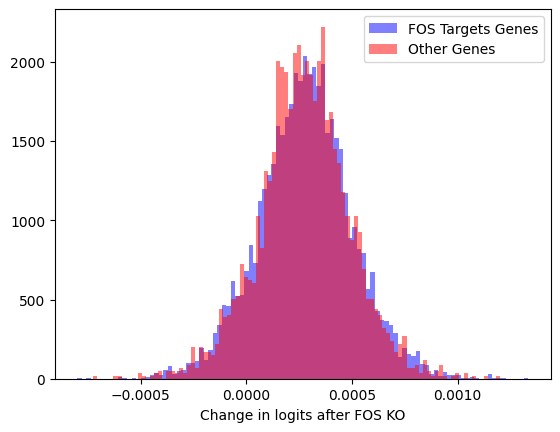

In [24]:
plt.hist(fos_targets_delta.mean(dim=0).detach().cpu().numpy(), density=True, color='blue', alpha=0.5, bins=100, label='FOS Targets Genes')
plt.hist(fos_others_delta.mean(dim=0).detach().cpu().numpy(), density=True, color='red', alpha=0.5, bins=100, label='Other Genes')
plt.legend()
plt.xlabel('Change in logits after FOS KO')
plt.show()

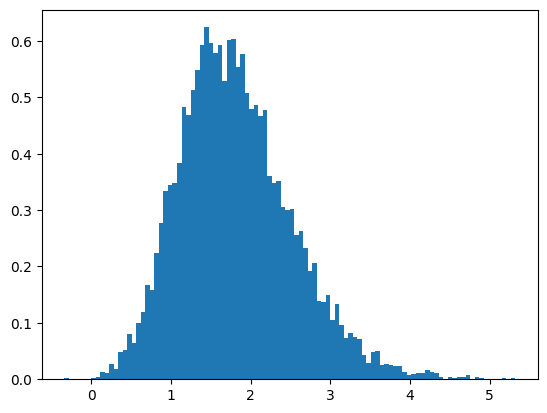

In [28]:
all_fos_deltas = fos_targets_delta - control_targets
plt.hist(all_fos_deltas.detach().cpu().numpy().mean(axis=0), bins=100, density=True);

In [29]:
probs_fos_ko_targets = probs_fos_ko[:, FOS_targets_mask]
probs_fos_ko_others = probs_fos_ko[:, ~FOS_targets_mask]

probs_control_targets = probs_control[:, FOS_targets_mask]
probs_control_others = probs_control[:, ~FOS_targets_mask]

probs_fos_ko_targets.shape, probs_fos_ko_others.shape

(torch.Size([11990, 7726]), torch.Size([11990, 3083]))

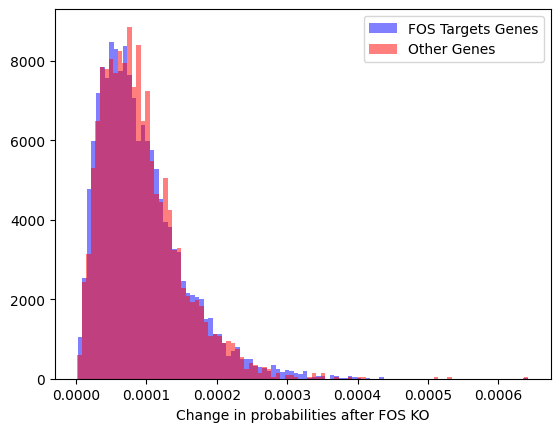

In [64]:
plt.hist(probs_fos_ko_targets.mean(dim=0).detach().cpu().numpy(), density=True, color='blue', alpha=0.5, bins=100, label='FOS Targets Genes')
plt.hist(probs_fos_ko_others.mean(dim=0).detach().cpu().numpy(), density=True, color='red', alpha=0.5, bins=100, label='Other Genes')
plt.legend()
plt.xlabel('Change in probabilities after FOS KO')
plt.show()

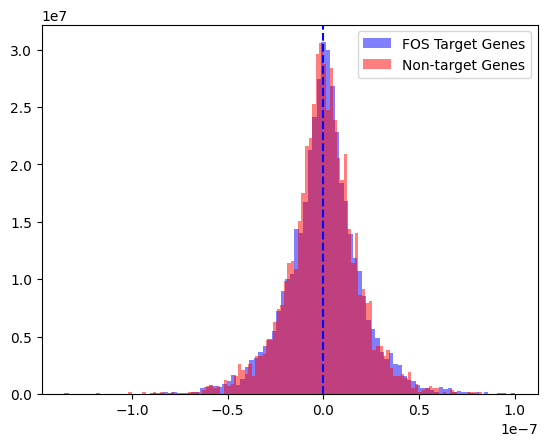

In [36]:
plt.hist((probs_fos_ko_targets - probs_control_targets).detach().numpy().mean(axis=0),
          bins=100, density=True, alpha=0.5, 
          color='blue', label='FOS Target Genes');
plt.hist((probs_fos_ko_others - probs_control_others).detach().numpy().mean(axis=0),
            bins=100, density=True, alpha=0.5, 
            color='red', label='Non-target Genes');
plt.axvline((probs_fos_ko_targets - probs_control_targets).detach().numpy().mean(axis=0).mean(), color='blue', linestyle='--')
plt.legend();

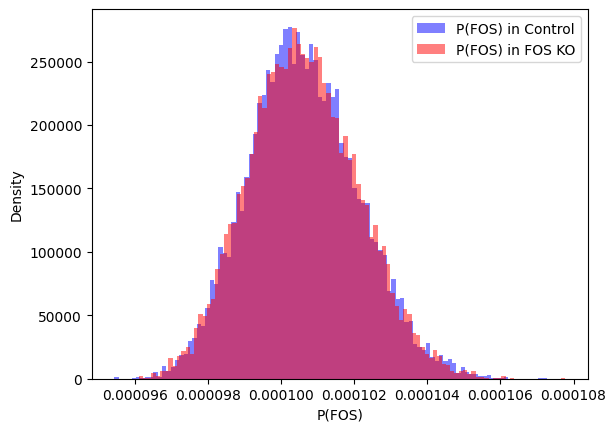

In [38]:
FOS_prob_control = probs_control[:, 7506].detach().cpu().numpy()
FOS_prob_fos_ko = probs_fos_ko[:, 7506].detach().cpu().numpy()

plt.hist(FOS_prob_control, bins=100, density=True, alpha=0.5, color='blue', label='P(FOS) in Control')
plt.hist(FOS_prob_fos_ko, bins=100, density=True, alpha=0.5, color='red', label='P(FOS) in FOS KO')
plt.xlabel('P(FOS)')
plt.ylabel('Density')
plt.legend()

In [46]:
# check change in ARID3A knockout
results_arid3a_removed_targets = results_arid3a_removed_torch[:, ARID3A_targets_mask]
results_arid3a_removed_others = results_arid3a_removed_torch[:, ~ARID3A_targets_mask]

control_targets_arid3a = results_control_torch[:, ARID3A_targets_mask]
control_others_arid3a = results_control_torch[:, ~ARID3A_targets_mask]

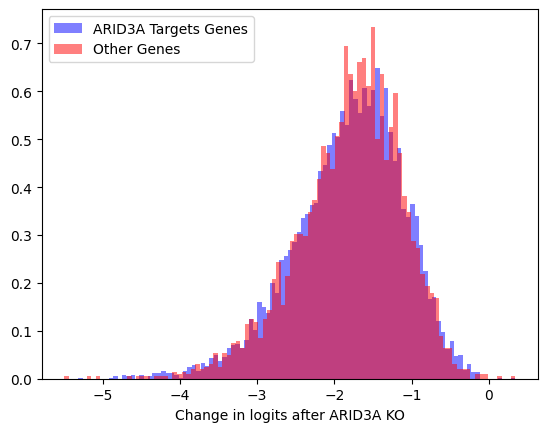

In [47]:
plt.hist(results_arid3a_removed_targets.mean(dim=0).detach().cpu().numpy(), density=True, color='blue', alpha=0.5, bins=100, label='ARID3A Targets Genes')
plt.hist(results_arid3a_removed_others.mean(dim=0).detach().cpu().numpy(), density=True, color='red', alpha=0.5, bins=100, label='Other Genes')
plt.legend()
plt.xlabel('Change in logits after ARID3A KO')
plt.show()

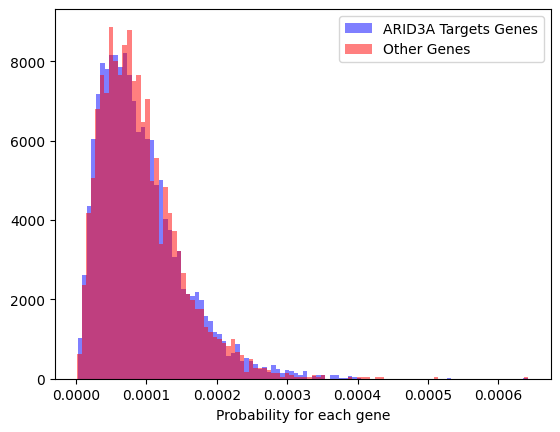

In [49]:
probs_arid3a_removed_targets = probs_arid3a_removed[:, ARID3A_targets_mask]
probs_arid3a_removed_others = probs_arid3a_removed[:, ~ARID3A_targets_mask]

probs_control_targets_arid3a = probs_control[:, ARID3A_targets_mask]
probs_control_others_arid3a = probs_control[:, ~ARID3A_targets_mask]

plt.hist(probs_arid3a_removed_targets.mean(dim=0).detach().cpu().numpy(), density=True, color='blue', alpha=0.5, bins=100, label='ARID3A Targets Genes')
plt.hist(probs_arid3a_removed_others.mean(dim=0).detach().cpu().numpy(), density=True, color='red', alpha=0.5, bins=100, label='Other Genes')
plt.legend()
plt.xlabel('Probability for each gene')
plt.show()

In [50]:
control_adata.var['gene_symbols'].to_list().index('ARID3A')

9591

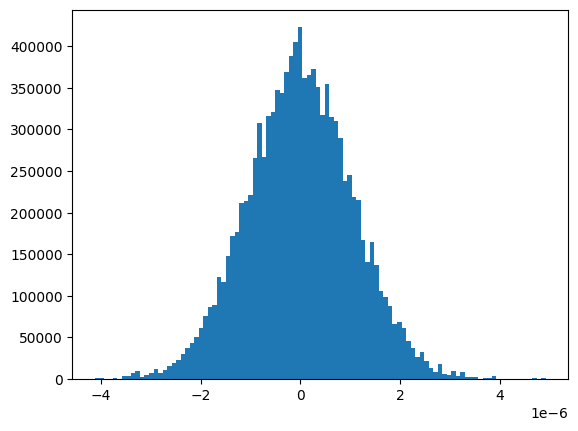

In [56]:
plt.hist((probs_arid3a_removed[:,9591] - probs_control[:,9591]).detach().cpu().numpy(), bins=100, density=True);

In [57]:
probs_control

tensor([[2.2399e-05, 1.0862e-04, 1.0372e-04,  ..., 1.1341e-04, 7.2916e-05,
         8.6754e-05],
        [2.2540e-05, 1.0947e-04, 1.0419e-04,  ..., 1.1500e-04, 7.4551e-05,
         8.8397e-05],
        [2.1827e-05, 1.0934e-04, 1.0441e-04,  ..., 1.1833e-04, 7.5690e-05,
         8.7906e-05],
        ...,
        [2.2655e-05, 1.0654e-04, 1.0505e-04,  ..., 1.1829e-04, 7.4840e-05,
         9.1813e-05],
        [2.2349e-05, 1.1592e-04, 1.0364e-04,  ..., 1.1758e-04, 7.5965e-05,
         8.7817e-05],
        [2.2027e-05, 1.0999e-04, 1.0376e-04,  ..., 1.1548e-04, 7.5220e-05,
         8.5680e-05]])

In [55]:
(probs_arid3a_removed[:,9591] - probs_arid3a_removed[:,9591])

tensor([0., 0., 0.,  ..., 0., 0., 0.])